# Compound Events Analysis

### This is a notebook combining precipitation and temperature data analysis from the ERA5 dataset.

In [2]:
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import rasterio
import rioxarray
import seaborn as sns
from scipy.stats import linregress

In [3]:
# Load temperature dataset
temperature_data = xr.open_dataset("Data/2m-temp-2014-2024-full.nc")
temperature_celsius = temperature_data["t2m"] - 273.15  # Convert from Kelvin to Celsius
temperature_df = temperature_celsius.to_dataframe().reset_index()

# Load precipitation dataset
precipitation_data = xr.open_dataset("Data/precip-2014-2024-full.nc")
precipitation_mm = precipitation_data["tp"] * 1000  # Convert from meters to mm
precipitation_df = precipitation_mm.to_dataframe().reset_index()

In [4]:
# Convert time column to datetime format
temperature_df["valid_time"] = pd.to_datetime(temperature_df["valid_time"])

# Find the hottest day (max temperature in any grid cell per day)
daily_max_temp = temperature_df.groupby("valid_time")["t2m"].max()
hottest_day = daily_max_temp.idxmax()  # Get the date of the hottest recorded temp
hottest_temp = daily_max_temp.max()  # Get the value of the hottest temperature

# Print results
print(f"Hottest recorded temperature: {hottest_temp:.2f}°C on {hottest_day.date()}")


Hottest recorded temperature: 47.97°C on 2024-07-12


In [5]:
# Ensure valid_time is in datetime format
precipitation_df["valid_time"] = pd.to_datetime(precipitation_df["valid_time"])

# Extract the date from valid_time
precipitation_df["date"] = precipitation_df["valid_time"].dt.date

# Step 1: Find the rainiest grid cell per day (max single-cell precipitation)
rainiest_cells_per_day = precipitation_df.groupby(["date", "latitude", "longitude"])["tp"].sum().reset_index()

# Step 2: Get the max precipitation grid cell per day (most intense cell for the day)
max_precip_per_day = rainiest_cells_per_day.loc[
    rainiest_cells_per_day.groupby("date")["tp"].idxmax()
]

# Step 3: Identify the single most extreme precipitation day
rainiest_day = max_precip_per_day.loc[max_precip_per_day["tp"].idxmax(), "date"]
rainiest_precip = max_precip_per_day["tp"].max()

# Print result
print(f"Most extreme precipitation: {rainiest_precip:.5f} mm on {rainiest_day}")


Most extreme precipitation: 39.10247 mm on 2015-11-24


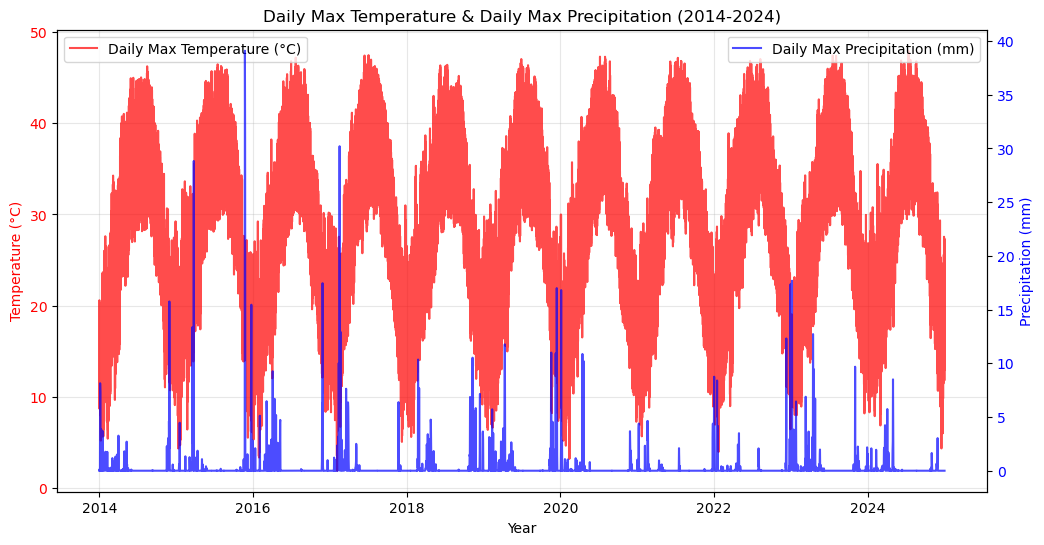

In [6]:
# Step 1: Compute daily max temperature (hottest grid cell per day)
daily_max_temp = temperature_df.groupby("valid_time")["t2m"].max()

# Step 2: Compute daily max precipitation (total daily sum from the rainiest grid cell)
precipitation_df["date"] = precipitation_df["valid_time"].dt.date
rainiest_cells_per_day = precipitation_df.groupby(["date", "latitude", "longitude"])["tp"].sum().reset_index()
max_precip_per_day = rainiest_cells_per_day.loc[rainiest_cells_per_day.groupby("date")["tp"].idxmax()]
max_precip_per_day = max_precip_per_day.set_index("date")["tp"]

# Step 3: Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot temperature on primary y-axis
ax1.plot(daily_max_temp.index, daily_max_temp, color="red", alpha=0.7, label="Daily Max Temperature (°C)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Temperature (°C)", color="red")
ax1.tick_params(axis="y", labelcolor="red")
ax1.grid(alpha=0.3)

# Create a secondary y-axis for precipitation
ax2 = ax1.twinx()
ax2.plot(max_precip_per_day.index, max_precip_per_day, color="blue", alpha=0.7, label="Daily Max Precipitation (mm)")
ax2.set_ylabel("Precipitation (mm)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Add a title and legends
plt.title("Daily Max Temperature & Daily Max Precipitation (2014-2024)")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()


In [7]:
# Ensure correct datetime format
temperature_df["valid_time"] = pd.to_datetime(temperature_df["valid_time"])

# Fix: Resample temperature to ensure true daily max values
daily_max_temp = temperature_df.set_index("valid_time").resample("1D")["t2m"].max()

# Reset index for consistency with PDF version
daily_max_temp = daily_max_temp.reset_index()
daily_max_temp.columns = ["valid_time", "Max Temperature (°C)"]  # Match PDF naming

# Fix: Import NumPy before using np.percentile()
import numpy as np

# Apply the heatwave detection logic
percentile_95 = np.percentile(daily_max_temp["Max Temperature (°C)"], 95)
daily_max_temp["Heatwave Day"] = daily_max_temp["Max Temperature (°C)"] >= percentile_95

# Detect consecutive heatwave periods (3+ days)
heatwaves = []
current_heatwave = []

for i, row in daily_max_temp.iterrows():
    if row["Heatwave Day"]:
        current_heatwave.append(row)
    else:
        if len(current_heatwave) >= 3:
            heatwaves.append(pd.DataFrame(current_heatwave))  # Store only 3+ day heatwaves
        current_heatwave = []

# Final check for the last ongoing heatwave
if len(current_heatwave) >= 3:
    heatwaves.append(pd.DataFrame(current_heatwave))

# Process heatwave data
heatwave_data = []

for hw in heatwaves:
    start_date = hw["valid_time"].iloc[0]
    end_date = hw["valid_time"].iloc[-1]
    duration = len(hw)
    max_temps = hw["Max Temperature (°C)"].values

    heatwave_data.append({
        "Start Date": start_date,
        "End Date": end_date,
        "Duration (days)": duration,
        "Max Temps Per Day (°C)": list(max_temps)
    })

# Convert to DataFrame
heatwave_df = pd.DataFrame(heatwave_data)

# Display heatwave summary
print(f"Total Heatwaves Detected: {len(heatwave_df)}")
print(f"Longest Heatwave Duration: {heatwave_df['Duration (days)'].max()} days")
print(f"Average Heatwave Duration: {heatwave_df['Duration (days)'].mean():.2f} days")


Total Heatwaves Detected: 35
Longest Heatwave Duration: 7 days
Average Heatwave Duration: 4.17 days


In [8]:
# Step 1: Ensure correct datetime format
precipitation_df["valid_time"] = pd.to_datetime(precipitation_df["valid_time"])

# Step 2: Extract the date from valid_time
precipitation_df["date"] = precipitation_df["valid_time"].dt.date

# Step 3: Find the rainiest grid cell per day (max single-cell precipitation)
rainiest_cells_per_day = precipitation_df.groupby(["date", "latitude", "longitude"])["tp"].sum().reset_index()

# Step 4: Get the max precipitation grid cell per day (most intense cell for the day)
max_precip_per_day = rainiest_cells_per_day.loc[
    rainiest_cells_per_day.groupby("date")["tp"].idxmax()
]

# Step 5: Compute 98th, 99th, and 99.9th percentile thresholds
percentile_999 = np.percentile(max_precip_per_day["tp"], 99.9)
percentile_99 = np.percentile(max_precip_per_day["tp"], 99)
percentile_98 = np.percentile(max_precip_per_day["tp"], 98)

# Step 6: Identify extreme precipitation days
max_precip_per_day["Rainfall Category"] = np.where(
    max_precip_per_day["tp"] >= percentile_999, "99.9th Percentile",
    np.where(max_precip_per_day["tp"] >= percentile_99, "99th Percentile",
             np.where(max_precip_per_day["tp"] >= percentile_98, "98th Percentile", None))
)

# Step 7: Filter to keep only extreme rainfall days (remove NaN values)
extreme_rainfall_days = max_precip_per_day.dropna(subset=["Rainfall Category"])

# Display results
print(f"Total Extreme Rainfall Days: {len(extreme_rainfall_days)}")
print(extreme_rainfall_days.head())


Total Extreme Rainfall Days: 81
            date  latitude  longitude         tp Rainfall Category
76    2014-01-05    25.125     46.375   8.142104   99th Percentile
91    2014-01-06    24.875     47.125   7.312131   98th Percentile
5311  2014-11-28    25.125     47.125   4.616222   98th Percentile
5340  2014-11-30    25.125     46.375  15.756607   99th Percentile
5345  2014-12-01    24.375     46.625   6.152196   98th Percentile


In [9]:
# Define path to the output folder relative to the notebook
output_folder = "Outputs_CEs"

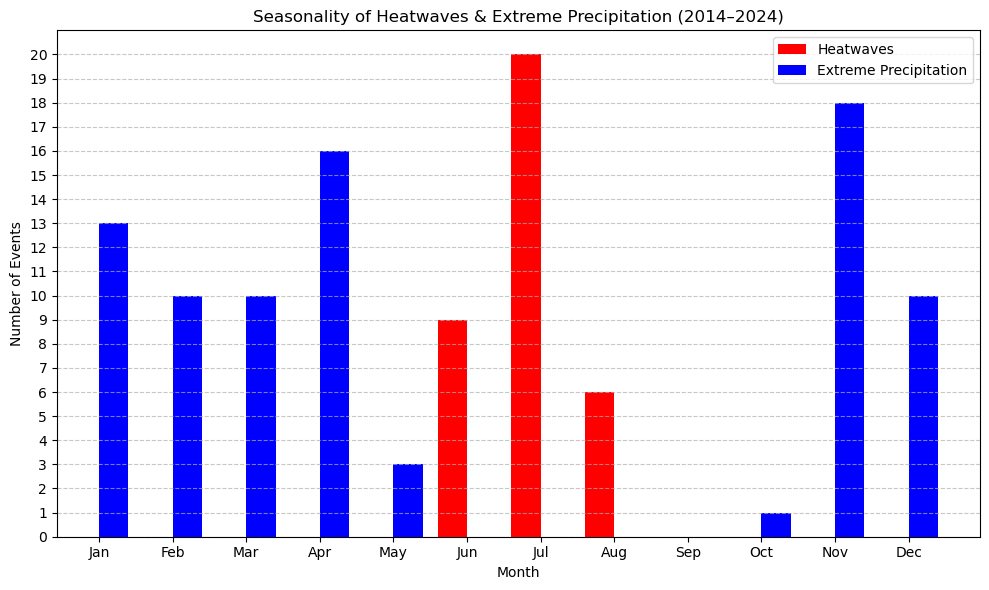

In [10]:
# Step 1: Extract months from both datasets
heatwave_df["Month"] = heatwave_df["Start Date"].dt.month
extreme_rainfall_days = extreme_rainfall_days.copy()  # FIX: Ensure we're modifying a copy
extreme_rainfall_days.loc[:, "Month"] = pd.to_datetime(extreme_rainfall_days["date"]).dt.month  # FIXED

# Step 2: Count events per month
heatwave_counts = heatwave_df["Month"].value_counts().sort_index()
rainfall_counts = extreme_rainfall_days["Month"].value_counts().sort_index()

# Step 3: Plot the data
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(heatwave_counts.index - 0.2, heatwave_counts.values, width=0.4, color="red", label="Heatwaves")
ax.bar(rainfall_counts.index + 0.2, rainfall_counts.values, width=0.4, color="blue", label="Extreme Precipitation")

# Customize plot
ax.set_xticks(range(1, 13))
ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
ax.set_xlabel("Month")
ax.set_ylabel("Number of Events")
ax.set_title("Seasonality of Heatwaves & Extreme Precipitation (2014–2024)")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Ensure Y-Axis Only Shows Whole Numbers
ax.set_yticks(np.arange(0, max(heatwave_counts.max(), rainfall_counts.max()) + 1, 1))  # Only whole numbers

# Show the plot
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "seasonality-heatwaves-extreme-precip.png"), dpi=300, bbox_inches="tight")
plt.show()


In [11]:
# Ensure dates are in datetime format
extreme_rainfall_days["date"] = pd.to_datetime(extreme_rainfall_days["date"])
heatwave_df["Start Date"] = pd.to_datetime(heatwave_df["Start Date"])

# Sort both datasets by date
extreme_rainfall_days = extreme_rainfall_days.sort_values("date")
heatwave_df = heatwave_df.sort_values("Start Date")

# Step 1: Find the nearest future heatwave for each extreme rain event
min_time_gaps = []
for _, rain_event in extreme_rainfall_days.iterrows():
    rain_date = rain_event["date"]
    
    # Find the first heatwave that happens *after* this rain event
    future_heatwave = heatwave_df[heatwave_df["Start Date"] > rain_date]
    
    if not future_heatwave.empty:
        nearest_heatwave = future_heatwave.iloc[0]  # First future heatwave
        time_gap = (nearest_heatwave["Start Date"] - rain_date).days
        min_time_gaps.append(time_gap)

# Find the minimum time gap
if min_time_gaps:
    min_gap = min(min_time_gaps)
    print(f"Minimum time between an extreme precipitation event and the next heatwave: {min_gap} days")
else:
    print("No extreme precipitation events were followed by a heatwave in the dataset.")


Minimum time between an extreme precipitation event and the next heatwave: 42 days


In [12]:
# Ensure dates are in datetime format
extreme_rainfall_days["date"] = pd.to_datetime(extreme_rainfall_days["date"])
heatwave_df["Start Date"] = pd.to_datetime(heatwave_df["Start Date"])

# Sort both datasets by date
extreme_rainfall_days = extreme_rainfall_days.sort_values("date")
heatwave_df = heatwave_df.sort_values("Start Date")

# Step 1: Find the nearest future heatwave for each extreme rain event
time_gaps = []
for _, rain_event in extreme_rainfall_days.iterrows():
    rain_date = rain_event["date"]
    
    # Find the first heatwave that happens after this rain event
    future_heatwave = heatwave_df[heatwave_df["Start Date"] > rain_date]
    
    if not future_heatwave.empty:
        nearest_heatwave = future_heatwave.iloc[0]  # First future heatwave
        time_gap = (nearest_heatwave["Start Date"] - rain_date).days
        time_gaps.append({
            "Extreme Rain Date": rain_date,
            "Heatwave Start Date": nearest_heatwave["Start Date"],
            "Time Gap (Days)": time_gap
        })

# Convert to DataFrame
time_gaps_df = pd.DataFrame(time_gaps)

# Get the top 10 minimum time gaps
top_10_min_gaps = time_gaps_df.nsmallest(10, "Time Gap (Days)")

# Display results
print("Top 10 Shortest Gaps Between Extreme Rain and Heatwaves:")
print(top_10_min_gaps)

# Save results to a CSV file
top_10_min_gaps.to_csv(os.path.join(output_folder, "top_10_shortest_gaps.csv"), index=False)

Top 10 Shortest Gaps Between Extreme Rain and Heatwaves:
   Extreme Rain Date Heatwave Start Date  Time Gap (Days)
37        2018-04-25          2018-06-06               42
80        2024-05-01          2024-06-19               49
79        2024-04-30          2024-06-19               50
58        2020-04-21          2020-06-29               69
57        2020-04-20          2020-06-29               70
21        2016-05-10          2016-07-21               72
20        2016-05-09          2016-07-21               73
76        2023-04-26          2023-07-08               73
48        2019-04-13          2019-06-26               74
47        2019-04-12          2019-06-26               75


In [13]:
# Ensure dates are in datetime format
extreme_rainfall_days["date"] = pd.to_datetime(extreme_rainfall_days["date"])
heatwave_df["Start Date"] = pd.to_datetime(heatwave_df["Start Date"])

# Filter for flood events occurring in March, April, and May
extreme_rainfall_days = extreme_rainfall_days[
    extreme_rainfall_days["date"].dt.month.isin([3, 4, 5])
]

# Sort both datasets by date
extreme_rainfall_days = extreme_rainfall_days.sort_values("date")
heatwave_df = heatwave_df.sort_values("Start Date")

# Step 1: Find the nearest future heatwave for each extreme rain event
time_gaps = []
for _, rain_event in extreme_rainfall_days.iterrows():
    rain_date = rain_event["date"]
    
    # Find the first heatwave that happens after this rain event
    future_heatwave = heatwave_df[heatwave_df["Start Date"] > rain_date]
    
    if not future_heatwave.empty:
        nearest_heatwave = future_heatwave.iloc[0]  # First future heatwave
        time_gap = (nearest_heatwave["Start Date"] - rain_date).days
        time_gaps.append({
            "Extreme Rain Date": rain_date,
            "Heatwave Start Date": nearest_heatwave["Start Date"],
            "Time Gap (Days)": time_gap
        })

# Convert to DataFrame
time_gaps_df = pd.DataFrame(time_gaps)

# Calculate the average time gap
average_time_gap = time_gaps_df["Time Gap (Days)"].mean()

# Display results
print("Time Gaps Between Spring Flood Events (March-May) and the Next Heatwave:")
print(time_gaps_df)

# Corrected f-string statement
print(f"\nAverage Time Gap (March-May Flood Events): {average_time_gap:.2f} days")

# Save results to CSV
time_gaps_df.to_csv(os.path.join(output_folder, "spring_flood_time_gaps.csv"), index=False)


Time Gaps Between Spring Flood Events (March-May) and the Next Heatwave:
   Extreme Rain Date Heatwave Start Date  Time Gap (Days)
0         2015-03-19          2015-07-15              118
1         2015-03-22          2015-07-15              115
2         2015-03-26          2015-07-15              111
3         2016-03-06          2016-07-21              137
4         2016-03-07          2016-07-21              136
5         2016-04-04          2016-07-21              108
6         2016-04-13          2016-07-21               99
7         2016-04-20          2016-07-21               92
8         2016-05-09          2016-07-21               73
9         2016-05-10          2016-07-21               72
10        2017-03-19          2017-06-13               86
11        2017-03-28          2017-06-13               77
12        2017-03-29          2017-06-13               76
13        2018-03-01          2018-06-06               97
14        2018-04-25          2018-06-06               42

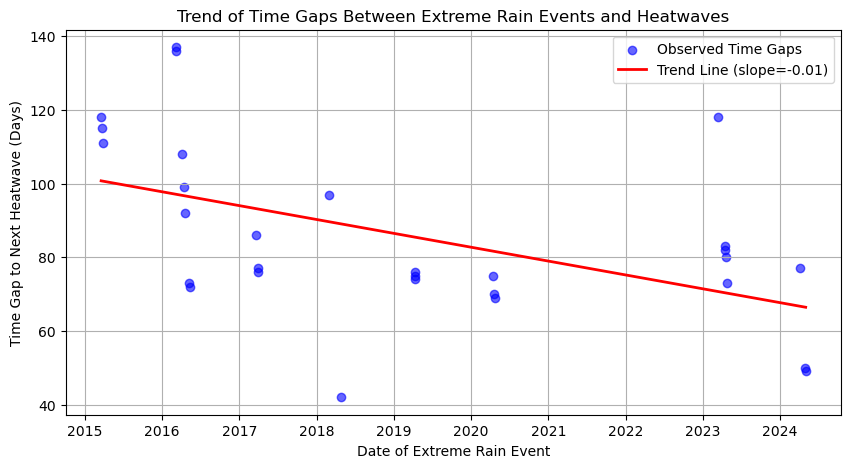


Linear Regression Results:
Slope: -0.0103
Intercept: 100.73
R-squared: 0.2543
P-value: 0.0053 (Significance Test)
Standard Error: 0.0034

✅ The trend is statistically significant (p < 0.05).
➡ The time gap between extreme rainfall and heatwaves is decreasing over time.


In [14]:
# Load the dataset (Replace with actual file paths if necessary)
time_gaps_df = pd.read_csv(os.path.join(output_folder,"spring_flood_time_gaps.csv"))

# Ensure datetime format
time_gaps_df["Extreme Rain Date"] = pd.to_datetime(time_gaps_df["Extreme Rain Date"])

# Sort the dataset by date
time_gaps_df = time_gaps_df.sort_values("Extreme Rain Date")

# Convert dates to numerical values (days since the first recorded event)
time_gaps_df["Days Since Start"] = (time_gaps_df["Extreme Rain Date"] - time_gaps_df["Extreme Rain Date"].min()).dt.days

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    time_gaps_df["Days Since Start"], time_gaps_df["Time Gap (Days)"]
)

# Generate trend line
trend_line = intercept + slope * time_gaps_df["Days Since Start"]

# Plot results
plt.figure(figsize=(10, 5))
plt.scatter(
    time_gaps_df["Extreme Rain Date"],
    time_gaps_df["Time Gap (Days)"],
    label="Observed Time Gaps",
    color="blue",
    alpha=0.6
)
plt.plot(
    time_gaps_df["Extreme Rain Date"],
    trend_line,
    label=f"Trend Line (slope={slope:.2f})",
    color="red",
    linewidth=2
)
plt.xlabel("Date of Extreme Rain Event")
plt.ylabel("Time Gap to Next Heatwave (Days)")
plt.title("Trend of Time Gaps Between Extreme Rain Events and Heatwaves")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_folder, "time-gaps-rain-heat-linear-regression.png"), dpi=300, bbox_inches="tight")
plt.show()

# Display regression results
print("\nLinear Regression Results:")
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.2f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f} (Significance Test)")
print(f"Standard Error: {std_err:.4f}")

# Interpretation
if p_value < 0.05:
    print("\n✅ The trend is statistically significant (p < 0.05).")
    print("➡ The time gap between extreme rainfall and heatwaves is decreasing over time.")
else:
    print("\n❌ The trend is NOT statistically significant (p >= 0.05).")
    print("➡ There is no strong evidence of a decreasing trend.")


In [15]:
# Step 1: Ensure correct datetime format
precipitation_df["valid_time"] = pd.to_datetime(precipitation_df["valid_time"])
precipitation_df["date"] = precipitation_df["valid_time"].dt.date

# Step 2: Sum precip over time at each grid cell per day
rainiest_cells_per_day = precipitation_df.groupby(["date", "latitude", "longitude"])["tp"].sum().reset_index()

# Step 3: Find max single grid cell for each day
max_precip_per_day = rainiest_cells_per_day.loc[
    rainiest_cells_per_day.groupby("date")["tp"].idxmax()
].copy()

# Step 4: Add year
max_precip_per_day["Year"] = pd.to_datetime(max_precip_per_day["date"]).dt.year

# Step 5: Compute percentiles
percentile_999 = np.percentile(max_precip_per_day["tp"], 99.9)
percentile_99 = np.percentile(max_precip_per_day["tp"], 99)
percentile_98 = np.percentile(max_precip_per_day["tp"], 98)

# Step 6: Add percentile category
def assign_percentile(value):
    if value >= percentile_999:
        return "99.9th"
    elif value >= percentile_99:
        return "99th"
    elif value >= percentile_98:
        return "98th"
    else:
        return "<98th"

max_precip_per_day["Percentile"] = max_precip_per_day["tp"].apply(assign_percentile)

# Step 7: Filter to ≥ 98th percentile
extreme_rain = max_precip_per_day[max_precip_per_day["Percentile"] != "<98th"].copy()

# Rebuild the extreme_rainfall_days DataFrame from scratch, if needed
extreme_rainfall_days = max_precip_per_day[max_precip_per_day["Percentile"] != "<98th"].copy()
extreme_rainfall_days["Rainfall Category"] = extreme_rainfall_days["Percentile"]  # For consistency
extreme_rainfall_days["date"] = pd.to_datetime(extreme_rainfall_days["date"])      # Ensure datetime

# Step 8 (revised): Use all extreme rain events (≥98th percentile)
all_extreme_rain_events = extreme_rainfall_days.copy()
all_extreme_rain_events["date"] = pd.to_datetime(all_extreme_rain_events["date"])  # Ensure datetime

# Step 9: Match each rain event to the hottest day of the closest heatwave (same year)
records = []

for _, row in all_extreme_rain_events.iterrows():
    rain_date = row["date"]
    rain_mm = row["tp"]
    year = rain_date.year
    percentile = row["Rainfall Category"]

    # Filter heatwaves from the same year only
    same_year_heatwaves = heatwave_df[heatwave_df["Start Date"].dt.year == year]

    closest_day = None
    min_diff = pd.Timedelta(days=99999)
    max_temp = None

    for _, hw in same_year_heatwaves.iterrows():
        start = hw["Start Date"]
        temps = hw["Max Temps Per Day (°C)"]

        # Get all days of this heatwave
        hw_days = [start + pd.Timedelta(days=i) for i in range(len(temps))]

        # Compute time differences to rain date
        diffs = [abs((day - rain_date).days) for day in hw_days]
        closest_idx = np.argmin(diffs)
        this_diff = hw_days[closest_idx] - rain_date

        # Update if this heatwave is closer than previous best
        if abs(this_diff) < abs(min_diff):
            min_diff = this_diff
            closest_day = hw_days[np.argmax(temps)]  # Get the hottest day of the heatwave
            max_temp = max(temps)

    # Append result even if no heatwave found
    records.append({
        "Year": year,
        "Rain Date": rain_date.date(),
        "Rain (mm)": round(rain_mm, 2),
        "Heatwave Date": closest_day.date() if closest_day else None,
        "Max Temp (°C)": round(max_temp, 2) if max_temp else None,
        "Δ Days": min_diff.days if closest_day else None,
        "Percentile": percentile
    })

# Step 10: Build final DataFrame
compound_df = pd.DataFrame(records)

# Optional: Export to CSV
compound_df.to_csv(os.path.join(output_folder,"compound_all_extreme_rain_events.csv"), index=False)
print(compound_df)

    Year   Rain Date  Rain (mm) Heatwave Date  Max Temp (°C)  Δ Days  \
0   2014  2014-01-05       8.14    2014-08-16          46.26     222   
1   2014  2014-01-06       7.31    2014-08-16          46.26     221   
2   2014  2014-11-28       4.62    2014-08-16          46.26    -103   
3   2014  2014-11-30      15.76    2014-08-16          46.26    -105   
4   2014  2014-12-01       6.15    2014-08-16          46.26    -106   
..   ...         ...        ...           ...            ...     ...   
76  2023  2023-04-26       6.71    2023-07-08          46.04      73   
77  2023  2023-11-02       9.68    2023-08-29          46.60     -64   
78  2024  2024-04-03       5.74    2024-06-22          46.58      77   
79  2024  2024-04-30       8.50    2024-06-22          46.58      50   
80  2024  2024-05-01       4.54    2024-06-22          46.58      49   

   Percentile  
0        99th  
1        98th  
2        98th  
3        99th  
4        98th  
..        ...  
76       98th  
77     


✅ Analyzing only events at or above the 98th percentile
Total compound events in dataset: 81

📈 Rain → Heat Events:
Count: 52
Avg lag: 115.90 days
Median lag: 109.50 days
Standard deviation: 45.39 days

🌡️ Heat → Rain Events:
Count: 29
Avg lag: -124.24 days
Median lag: -126.00 days
Standard deviation: 20.19 days

📊 Trend in Rain→Heat Lag: slope = -1.04 days/year (R² = 0.01, p = 0.611)
📊 Trend in Heat→Rain Lag: slope = 2.94 days/year (R² = 0.12, p = 0.062)


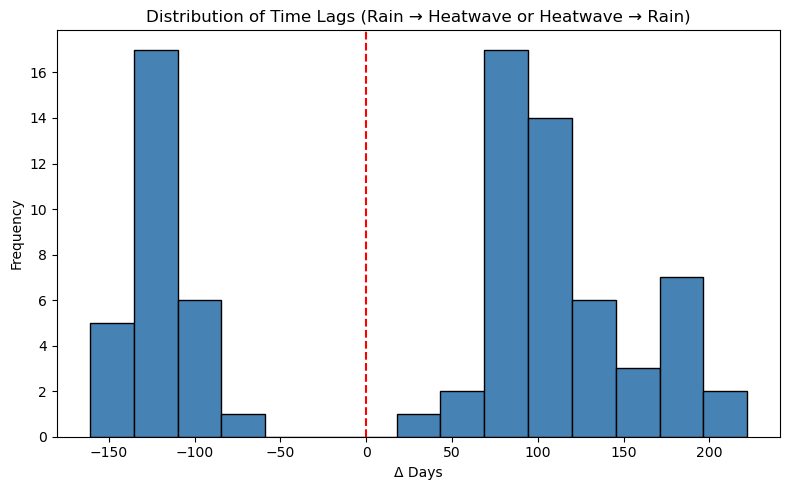

In [16]:
# Optional: Confirm the new threshold
print(f"\n✅ Analyzing only events at or above the 98th percentile")
print(f"Total compound events in dataset: {len(compound_df)}")

# Step 1: Separate directions
rain_to_heat = compound_df[compound_df["Δ Days"] > 0].copy()
heat_to_rain = compound_df[compound_df["Δ Days"] < 0].copy()

# Step 2: Summary stats
print("\n📈 Rain → Heat Events:")
print(f"Count: {len(rain_to_heat)}")
print(f"Avg lag: {rain_to_heat['Δ Days'].mean():.2f} days")
print(f"Median lag: {rain_to_heat['Δ Days'].median():.2f} days")
print(f"Standard deviation: {rain_to_heat['Δ Days'].std():.2f} days")

print("\n🌡️ Heat → Rain Events:")
print(f"Count: {len(heat_to_rain)}")
print(f"Avg lag: {heat_to_rain['Δ Days'].mean():.2f} days")
print(f"Median lag: {heat_to_rain['Δ Days'].median():.2f} days")
print(f"Standard deviation: {heat_to_rain['Δ Days'].std():.2f} days")

# Step 3: Trend analysis (rain to heat)
if not rain_to_heat.empty:
    slope_r2h, intercept, r_value, p_value, _ = linregress(rain_to_heat["Year"], rain_to_heat["Δ Days"])
    print(f"\n📊 Trend in Rain→Heat Lag: slope = {slope_r2h:.2f} days/year (R² = {r_value**2:.2f}, p = {p_value:.3f})")

if not heat_to_rain.empty:
    slope_h2r, intercept, r_value, p_value, _ = linregress(heat_to_rain["Year"], heat_to_rain["Δ Days"])
    print(f"📊 Trend in Heat→Rain Lag: slope = {slope_h2r:.2f} days/year (R² = {r_value**2:.2f}, p = {p_value:.3f})")

# Step 4: Plot distribution of time lags
plt.figure(figsize=(8, 5))
plt.hist(compound_df["Δ Days"], bins=15, color="steelblue", edgecolor="black")
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Time Lags (Rain → Heatwave or Heatwave → Rain)")
plt.xlabel("Δ Days")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


📈 Rain → Heat events: 52
🌡️ Heat → Rain events: 29


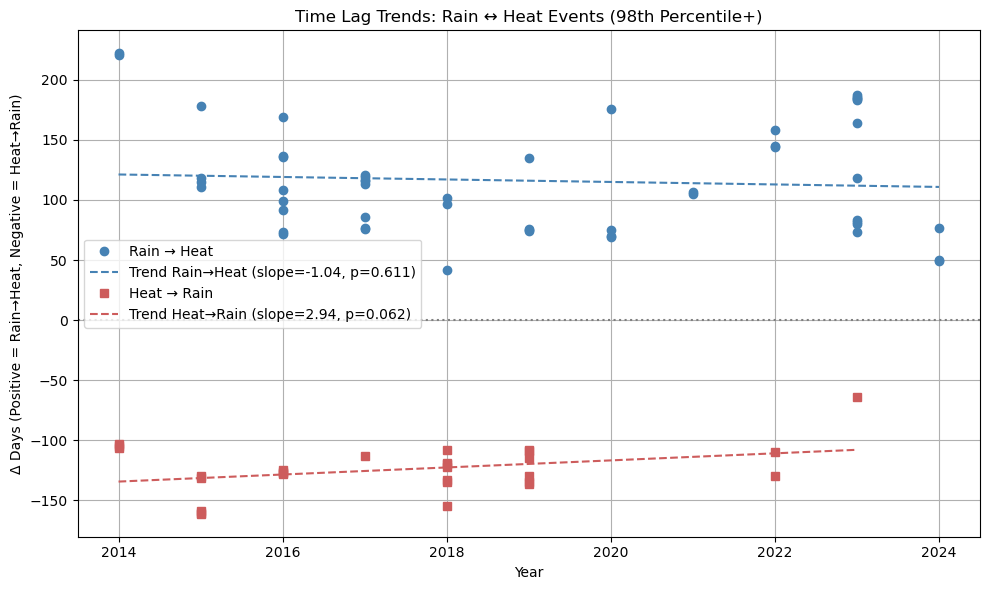

In [17]:
# Step 1: Split compound_df into Rain→Heat and Heat→Rain
rain_to_heat = compound_df[compound_df["Δ Days"] > 0].copy()
heat_to_rain = compound_df[compound_df["Δ Days"] < 0].copy()

print(f"📈 Rain → Heat events: {len(rain_to_heat)}")
print(f"🌡️ Heat → Rain events: {len(heat_to_rain)}")

# Step 2: Create the plot
plt.figure(figsize=(10, 6))

# Rain → Heat: blue circles and trend line
if not rain_to_heat.empty:
    slope_r2h, intercept_r2h, r_value_r2h, p_value_r2h, _ = linregress(
        rain_to_heat["Year"], rain_to_heat["Δ Days"]
    )
    trend_r2h = slope_r2h * rain_to_heat["Year"] + intercept_r2h
    plt.plot(rain_to_heat["Year"], rain_to_heat["Δ Days"], 'o', label="Rain → Heat", color="steelblue")
    plt.plot(rain_to_heat["Year"], trend_r2h, '--', color="steelblue",
             label=f"Trend Rain→Heat (slope={slope_r2h:.2f}, p={p_value_r2h:.3f})")

# Heat → Rain: red squares and trend line
if not heat_to_rain.empty:
    slope_h2r, intercept_h2r, r_value_h2r, p_value_h2r, _ = linregress(
        heat_to_rain["Year"], heat_to_rain["Δ Days"]
    )
    trend_h2r = slope_h2r * heat_to_rain["Year"] + intercept_h2r
    plt.plot(heat_to_rain["Year"], heat_to_rain["Δ Days"], 's', label="Heat → Rain", color="indianred")
    plt.plot(heat_to_rain["Year"], trend_h2r, '--', color="indianred",
             label=f"Trend Heat→Rain (slope={slope_h2r:.2f}, p={p_value_h2r:.3f})")

# Final plot styling
plt.axhline(0, color='gray', linestyle=':')
plt.title("Time Lag Trends: Rain ↔ Heat Events (98th Percentile+)")
plt.xlabel("Year")
plt.ylabel("Δ Days (Positive = Rain→Heat, Negative = Heat→Rain)")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Optional: Save and show
plt.savefig(os.path.join(output_folder,"directional-timelag-trends-rain-heat_98thplus.png"), dpi=300, bbox_inches="tight")
plt.show()
